## Matrix product state (MPS) decomposition of many-body states

The code developed in this notebook is based on the paper **'Efficient Classical Simulation of Slightly Entangled Quantum Computations'** by Guifré Vidal.

Consider a many-body system consisting of $N$ bodies/sites. Let $| i_l \rangle$ be a basis for the Hilber space of the site $l$. Any state in the Hilbert space of the entire system can be expresed as - 

$$ 
\Psi = \sum_{\{i\}} C_{\{i\}} | \{i\} \rangle
$$

where $\{i\} = i_1, i_2, i_3, \ldots i_N$

All the information about the state is contained in the complex tensor $C_{\{i\}}$. 

Assuming that each of the sites is a qubit, $2^N$ coefficients are needed to describe the state. 

When we do a matrix product decomposition as described in the paper, it is useful for further computational tasks as it takes $O(2ND^2)$ coefficients now to describe the state. $D$ is the chosen "bond dimension", i.e., the number of singular values (starting from the largest and going down) that are retained from the Schmidt decomposition across each bipartite cut of the many-body system. When the bond-dimension is allowed to be exponential in $N$, we can exactly match all $C_{\{i\}}$ and cover the entire Hilbert space. But for computational tasks, D is assumed to be upper bounded by a constant and this is the main approximation that is usually made when decomposing a general state. 

The entanglement entropy across an arbitrary cut scales as $log(D)$. So, if $D$ is upper bounded, so is the entanglement entropy and we restrict ourselves to a corner of the large Hilbert space of the entire system. We can only make good MPS approximations to states that are inside this corner. 

<img src="img_2.png">

In the following code, I have not restricted the bond-dimension and hence the decomposition is exact. 

The decomposition algorithm implemented in this notebook is described on page 2 of the paper. This algorithm decomposes a general state into what is called the 'standard canonical form' of the MPS where the singular values are apparent in the decomposition. 

These figures capture the gist of the algorithm - 

<img src="img_1.png">
<img src="img_3.png">
<img src="img_4.png">

Equations $\mathbf{(7)}$ to $\mathbf{(11)}$ form a succint description of the decomposition process and are exactly implemented in the method 'decompose' below. This routine returns the MPS decomposition which is stored as a python dictionary. From this returned dictionary, to access the tensors $\mathbf{\Gamma^{[l]}}$ from the paper, the index **'G' + str(l)** should be used. To access the tensors $\mathbf{\lambda^{[l]}}$ from the paper, the index **'G' + str(l) + ':' + str(l+1)** should be used. 

The method 'compose' forms the state tensor by contracting the MPS, i.e., performing tensor contractions on connected indices (the various $\alpha_l$ from the paper) of the MPS. It also returns the norm of the difference between the contracted tensor and the input tensor that allows us to look at the error in the decomposition.

The method 'entanglement_entropy' calculates the entanglement entropy across all bipartite cuts of the many-body system using the singular values across those cuts.

Random states are created using the method 'rand_ket' from qutip and are then reshaped into the correct tensor and input into the 'decompose' method.

The program below creates the matrix product decompositions for the 10 site GHZ state and 50 random states and prints the error in the decomposition. In all the cases, the error is zero (machine precision-limited) as the decomposition is exact. Figure 'GHZ state' shows the entanglement entropy vs. the bond number for the 10 site GHZ state. Figure 'Random states' captures the same information but for 50 randomly generated states.



In [1]:
%matplotlib inline
import numpy as np
import scipy.linalg as la
import scipy.sparse.linalg as sla
import matplotlib.pyplot as plt
from qutip import *

Error in GHZ10 decomposition = 0.0
Error in decomposition of random state 1 = 2.31770015554e-15
Error in decomposition of random state 2 = 2.28692394499e-15
Error in decomposition of random state 3 = 2.17211563403e-15
Error in decomposition of random state 4 = 2.26277415085e-15
Error in decomposition of random state 5 = 2.19117150905e-15
Error in decomposition of random state 6 = 2.98512053688e-15
Error in decomposition of random state 7 = 3.22846504233e-15
Error in decomposition of random state 8 = 2.42344684755e-15
Error in decomposition of random state 9 = 1.94579059739e-15
Error in decomposition of random state 10 = 1.93326920607e-15
Error in decomposition of random state 11 = 2.47656737269e-15
Error in decomposition of random state 12 = 2.78517465647e-15
Error in decomposition of random state 13 = 3.19750262839e-15
Error in decomposition of random state 14 = 2.2526598558e-15
Error in decomposition of random state 15 = 2.14772716532e-15
Error in decomposition of random state 16 = 2

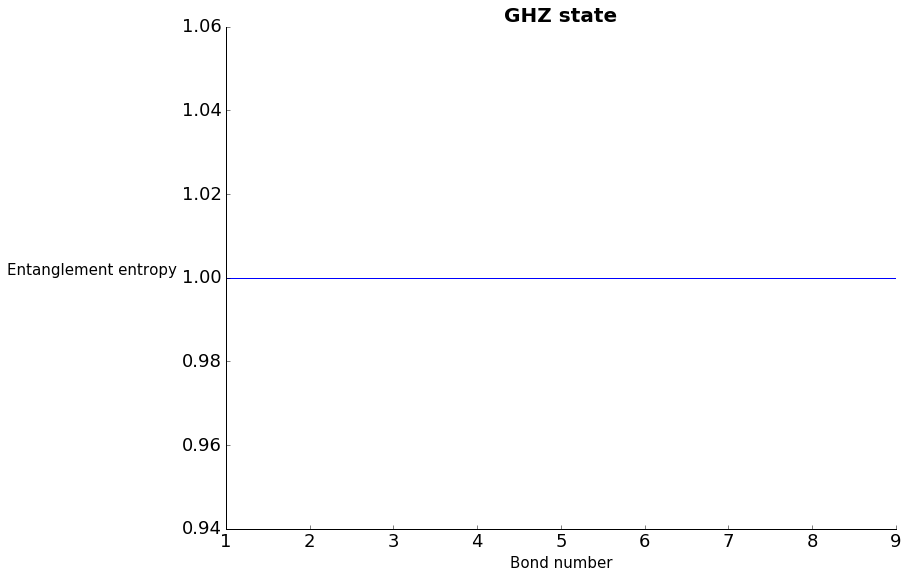

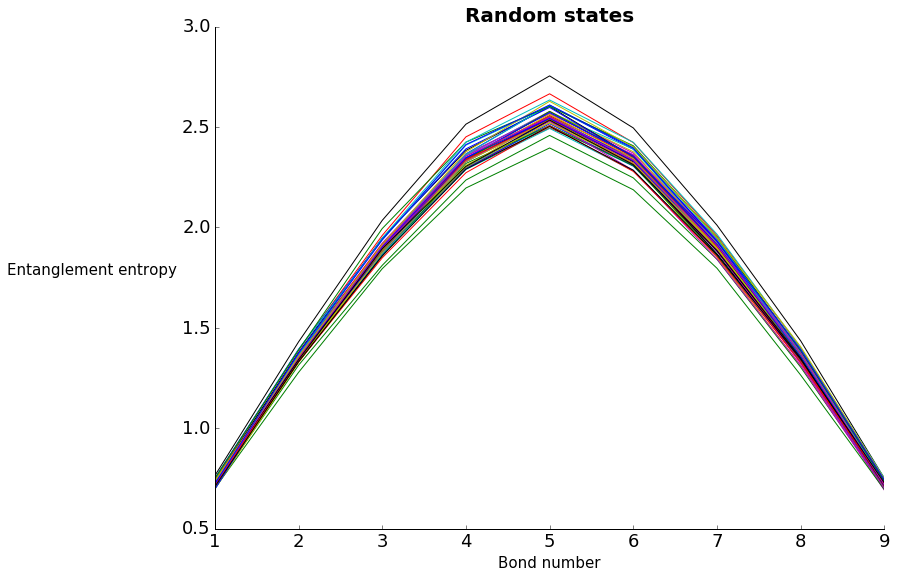

In [31]:
def decompose(C, tol = 1e-15):
    
    """
    Computes MPS decomposition of the many-body state given by the tensor (ndarray) C. tol = the minimum value of the singular values included in the decomposition
    
    Returns : Dictionary consisting of MPS matrices in canonical form (ndarrays). 
    """
    
    mps_dict = {};
    
    # The ndarray.shape attribute of C determines the dimensionality of the sites and the number of sites -> (i1, i2, ..., iN) where i are the physical dimensions
    
    N = C.ndim;
    bond_svs = [];
    bond_dims = [];
    bond_vh = [];
    
    # calculate the singular values and vectors across all bonds
    
    if (N == 2):
        
        s = 1;
        
        p = C.shape[0];
        
        C_reshaped = C.reshape(p, -1)

        u, sv, vh = la.svd(C_reshaped, full_matrices = False);

        u_de_zeroed = np.transpose(np.transpose(u)[sv > tol])     # columns are kets
        vh_de_zeroed = vh[sv > tol]                               # rows are kets
        sv_de_zeroed = sv[sv > tol]

        bond_svs.append(sv_de_zeroed);
        bond_dims.append(len(sv_de_zeroed)); 
        bond_vh.append(vh_de_zeroed);

        mps_dict['G' + str(s)] = u_de_zeroed;
        mps_dict['G' + str(s) + ':' + str(s+1)] = sv_de_zeroed;
        mps_dict['G' + str(s + 1)] = vh_de_zeroed.transpose();
        
        
    else : 
    
        for s in range(1, N): # s = bond location index not site

            if s-1 != 0 :
                p = np.prod(C.shape[0:s]);
            else :
                p = C.shape[0];

            C_reshaped = C.reshape(p, -1)

            u, sv, vh = la.svd(C_reshaped, full_matrices = False);

            u_de_zeroed = np.transpose(np.transpose(u)[sv > tol])     # columns are kets
            vh_de_zeroed = vh[sv > tol]                               # rows are kets
            sv_de_zeroed = sv[sv > tol]

            bond_svs.append(sv_de_zeroed);
            bond_dims.append(len(sv_de_zeroed)); 
            bond_vh.append(vh_de_zeroed);

            if (s == 1) : 

                mps_dict['G' + str(s)] = u_de_zeroed;
                mps_dict['G' + str(s) + ':' + str(s+1)] = sv_de_zeroed;

            elif (s == N - 1) :

                mps_dict['G' + str(s) + ':' + str(s+1)] = sv_de_zeroed;
                mps_dict['G' + str(s + 1)] = vh_de_zeroed.transpose();

            else : 

                mps_dict['G' + str(s) + ':' + str(s+1)] = sv_de_zeroed;



        for s in range(1, N-1): # s = bond location index not site

            # Form the local computational basis for site to the right of bond s

            d = C.shape[s]                          # physical dimension of site
            identity = np.eye(d)

            # Expand each Schmidt vector for site in comp. basis and make tau vectors

            schmidt_vectors_s = bond_vh[s-1];                       # ket but transposed (not a bra)
            schmidt_vectors_s1 = bond_vh[s];

            tau_vectors_s1 = np.zeros([d, bond_dims[s-1], np.prod(C.shape[s+1:])], dtype = complex);           # i, alpha(s), ...

            mps_dict['G' + str(s+1)] = np.zeros([d, bond_dims[s-1], bond_dims[s]], dtype = complex)            # i, alpha(s), alpha(s+1)

            alpha = 0;

            for v in schmidt_vectors_s: 

                for i in range(0,d):

                    projector = np.kron(identity[i, :], np.eye(np.prod(C.shape[s+1:])))

                    tau_vectors_s1[i, alpha, :] = projector @ v.transpose()

                    # Expand tau vectors in Schmidt vectors including and beyond site s + 1

                    alpha2 = 0;

                    for v2 in schmidt_vectors_s1:

                        x = v2.conjugate() @ tau_vectors_s1[i, alpha, :] / bond_svs[s][alpha2]

                        mps_dict['G' + str(s+1)][i, alpha, alpha2] = x;

                        alpha2 = alpha2 + 1;

                alpha = alpha + 1;

    return mps_dict
    
def compose(mps_dict, C_orig):
    
    """
    Computes the state tensor from the MPS decomposition
    
    Returns : the tensor and the error between the decomposition and the original tensor
    """
    
    N = int((len(mps_dict) + 1)/2);
    
    # C = 0;
    
    for s in range(1, N+1):
        
        if (s == 1):
            
            C = np.tensordot(mps_dict['G1'], np.diag(mps_dict['G1:2']), axes = ([1,0]))
            
        elif (s > 1 and s < N):
        
            C = np.tensordot(C, mps_dict['G' + str(s)], axes = ([s-1,1]))
            C = np.tensordot(C, np.diag(mps_dict['G' + str(s) + ':' + str(s+1)]), axes = ([s,0]))
        
        else:
            
            C = np.tensordot(C, mps_dict['G' + str(s)], axes = ([s-1,1]))
    
    return C, la.norm(C-C_orig)
    
    

def entanglement_entropy(mps_dict): 
    
    """
    Calculates site-wise entanglement entropy of a mps
    """
    
    N = int((len(mps_dict) + 1)/2);
    
    ee_list = [];
        
    for s in range(1,N):
                
        lambd = mps_dict['G' + str(s) + ':' + str(s+1)];
        sv = lambd; 
        
        ee = 0;
        
        for v in sv:
        
            ee = ee + (-v**2 * np.log2(v**2));
        
        ee_list.append(ee);
    
    return ee_list


GHZ10 = np.zeros([2 for n in range(10)]);
GHZ10[0,0,0,0,0,0,0,0,0,0] = 1/np.sqrt(2);
GHZ10[1,1,1,1,1,1,1,1,1,1] = 1/np.sqrt(2);

mps_GHZ10 = decompose(GHZ10);
ee_GHZ10 = entanglement_entropy(mps_GHZ10);

C_GHZ10, error_GHZ10 = compose(mps_GHZ10, GHZ10)

print("Error in GHZ10 decomposition = " + str(error_GHZ10))

fig, ax = plt.subplots(figsize=(12,9))

ax.plot(range(1,10), ee_GHZ10)

ax.spines["top"].set_visible(False)  
ax.spines["bottom"].set_visible(True)  
ax.spines["right"].set_visible(False)  
ax.spines["left"].set_visible(True)
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()  
plt.yticks(fontsize=18)  
plt.xticks(fontsize=18)
plt.title('GHZ state', fontsize = 20, fontweight = 'semibold')
ax.set_xlabel('Bond number', fontsize=15, fontweight = 550)
ax.set_ylabel('Entanglement entropy', fontsize=15, fontweight = 550, rotation = 'horizontal', ha = 'right')

random_states_ee = [];

for i in range(50):

    psi = rand_ket(2**10);
    psi_data = psi.full();

    psi_tensor = psi_data.reshape([2 for n in range(10)])

    mps_psi = decompose(psi_tensor);
    ee_psi = entanglement_entropy(mps_psi);

    random_states_ee.append(ee_psi);
    
    C_psi, error_psi = compose(mps_psi, psi_tensor)
    
    print("Error in decomposition of random state " + str(i+1) + " = " + str(error_psi))

fig, ax = plt.subplots(figsize=(12,9))

for i in range(50):
    ax.plot(range(1,10), random_states_ee[i])

ax.spines["top"].set_visible(False)  
ax.spines["bottom"].set_visible(True)  
ax.spines["right"].set_visible(False)  
ax.spines["left"].set_visible(True)
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()  
plt.yticks(fontsize=18)  
plt.xticks(fontsize=18)
plt.title('Random states', fontsize = 20, fontweight = 'semibold')
ax.set_xlabel('Bond number', fontsize=15, fontweight = 550)
ax.set_ylabel('Entanglement entropy', fontsize=15, fontweight = 550, rotation = 'horizontal', ha = 'right')

### References used

1 - http://theory.iphy.ac.cn/TNSAA2014/ppt/Garnet%20Chan%20.pptx 

2 - https://journals.aps.org/prl/pdf/10.1103/PhysRevLett.91.147902